# Assignment 3 - Convection of a Scalar

Solve the following problems and explain your results.

## Problem 1

Consider a convection/diffusion problem that has Dirichlet conditions on temperature imposed on both ends (see the figure below). This is an unusual problem that would be difficult to reproduce in a laboratory, but it is an interesting problem by which to observe the performance of advection schemes.

![Problem1](Figures/3-Problem1.png)
   
The exact solution to this problem is given by:

$$
    T(x)= T_1 + \frac{e^{x Pe/L} - 1}{e^{Pe} - 1}(T_2 - T_1)
$$

where $Pe$ is defined as $Pe= u L/\alpha$.  Solve this problem numerically for $Pe = 50$ by imposing:

- $L$ = 1 [m]
- $\rho$ = 1 [kg/m$^3$]
- $c_p$ = 1 [J/kg$\cdot$K]
- $u$ = 1 [m/s]
- $k$ = 0.02 [[W/m$\cdot$K]]
- $T_1$ = 0 [$^\circ$C]
- $T_2$ = 1 [$^\circ$C]

Discretize the one-dimensional domain using 10 equal sized control-volumes.  Initialize the field variables as $T$ = 0.0 [K] and $u$ = 1 [m/s]. Then, carry out the following:

1. Solve the problem using UDS, CDS, and QUICK (use $\Delta t = 10^{10}$ [s]).  Modify the value of $\alpha_e$ on the domain boundaries such that the value of temperature on the face is equal to the specified boundary temperature.
2. Plot the results for $T$ for all cases along with the exact solution. Discuss your results.
4. Re-run the case using 20, 40 and 80 uniformly spaced control volumes.  Discuss your results.

# Solution problem 1

In [260]:
import numpy as np

class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [-1] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [261]:
class CenteredAdvectionModel:
    """Class defining an upwind advection model with a central difference scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        self._alphae [-1] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie[1:-1] = (self._phi[1:-2] + self._phi[2:-1])/2
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = (self._cp*mdote[:-1])*self._phie[:-1]
        flux_e = (self._cp*mdote[1:])*self._phie[1:]
        
        #flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        #flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [262]:
import numpy as np

class QUICKAdvectionModel:
    """Class defining an upwind advection model with the QUICK scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [-1] = -1
        
        #To calculate the east integration point values of the interior control volume
        for i in range(self._grid.ncv):
            if self._Uhe[i] >= 0:
                TW = (((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i-1] - self._grid.xP[i])*(self._grid.xP[i-1] - self._grid.xP[i+1])))*self._phi[i-1]
                TP = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i+1]))/((self._grid.xP[i]-self._grid.xP[i-1])*(self._grid.xP[i]-self._grid.xP[i+1]))*self._phi[i]
                TE = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i]))/((self._grid.xP[i+1]-self._grid.xP[i-1])*(self._grid.xP[i+1]-self._grid.xP[i]))*self._phi[i+1] 
                self._phie[i] = TW + TP + TE
            
            #xW = grid.xP[i-1]
            #xP = grid.xP[i]
            #xE = grid.xP[i+1]
            #xe = grid.xf[i]
         # Calculate the east integration point values
        #self._phie = (((xe-xP)*(xe-xE))/((xW-xP)*(xE-xP)))*self._phi[0:-3] + (((xe-xW)*(xe-xE))/((xP-xW)*(xP-xE)))*self._phi[1:-2] + (((xe-xW)*(xe-xP))/((xE-xW)*(xE-xP)))*self._phi[2:-1]
            
        # Calculate the east integration point values for the boundaries
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]

        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

## Upwind Difference Scheme

In [263]:
from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel, FirstOrderTransientModel
from Classes.LinearSolver import solve

import numpy as np
from numpy.linalg import norm

def UDS(ncv1):

    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e9
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 0.02

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0
    U0 = 1

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 0, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 1, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the advection model
    advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
            
    return (T, grid.xP)


In [264]:
#UDS for a number of control volumes of 10
T_UDS1, grid1 = UDS(10)

#UDS for a number of control volumes of 20
T_UDS2, grid2 = UDS(20)

#UDS for a number of control volumes of 40
T_UDS3, grid3 = UDS(40)

#UDS for a number of control volumes of 80
T_UDS4, grid4 = UDS(80)

Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.0060000000000000045; Avg. Resid. = 0.0006000000000000005
Iteration = 1; Max. Resid. = 1.6186561484486144e-18; Avg. Resid. = 1.8642235209581962e-19
Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.0019999999999999723; Avg. Resid. = 9.999999999999861e-05
Iteration = 1; Max. Resid. = 7.042460704797287e-19; Avg. Resid. = 5.447947392095242e-20
Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.006000000000000057; Avg. Resid. = 0.00015000000000000142
Iteration = 1; Max. Resid. = 1.3955383274109578e-18; Avg. Resid. = 4.078630571981359e-20
Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.022000000000000117; Avg. Resid. = 0.0002750000000000015
Iteration = 1; Max. Resid. = 4.1704477156151555e-18; Avg. Resid. = 1.064177416889726e-19


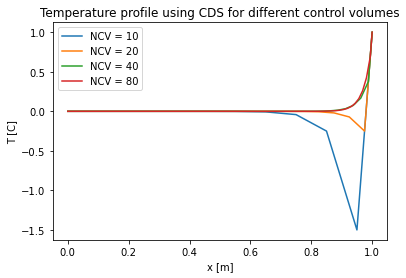

In [265]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax = plt.subplots()


ax.plot(grid1, T_UDS1, label="NCV = 10")
ax.plot(grid2, T_UDS2, label="NCV = 20")
ax.plot(grid3, T_UDS3, label="NCV = 40")
ax.plot(grid4, T_UDS4, label="NCV = 80")


ax.set_title("Temperature profile using CDS for different control volumes")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## Central Difference Scheme (CDS)

In [266]:
##FOR CENTRAL DIFFERENCE SCHEME

def CDS (ncv1):

    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 0.02

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0
    U0 = 1

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 0, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 1, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the advection model
    advection = CenteredAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
            
        
            
    return (T, grid.xP)

In [267]:
T_CDS1, grid1 = CDS(10)
T_CDS2, grid2 = CDS(20)
T_CDS3, grid3 = CDS(40)
T_CDS4, grid4 = CDS(80)



Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 0.0060000000000000045; Avg. Resid. = 0.0006000000000000005
Iteration = 1; Max. Resid. = 0.006249999734190473; Avg. Resid. = 0.001249999946838095
Iteration = 2; Max. Resid. = 0.004340281746190348; Avg. Resid. = 0.0008680563492380697
Iteration = 3; Max. Resid. = 0.002712644078661524; Avg. Resid. = 0.0005887446710998798
Iteration = 4; Max. Resid. = 0.0016325988067222553; Avg. Resid. = 0.0004245776098018456
Iteration = 5; Max. Resid. = 0.0011774502533086662; Avg. Resid. = 0.00029332892843522717
Iteration = 6; Max. Resid. = 0.0007521180267163978; Avg. Resid. = 0.00021287820449654467
Iteration = 7; Max. Resid. = 0.0005087178332219439; Avg. Resid. = 0.00014837087264301234
Iteration = 8; Max. Resid. = 0.00035579383936933887; Avg. Resid. = 0.00010703463437953232
Iteration = 9; Max. Resid. = 0.0002299079410688056; Avg. Resid. = 7.499710981372348e-05
Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 0.0019999999999999

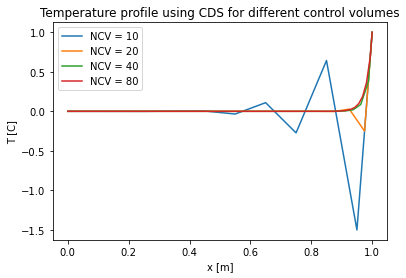

In [268]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax = plt.subplots()


ax.plot(grid1, T_CDS1, label="NCV = 10")
ax.plot(grid2, T_CDS2, label="NCV = 20")
ax.plot(grid3, T_CDS3, label="NCV = 40")
ax.plot(grid4, T_CDS4, label="NCV = 80")


ax.set_title("Temperature profile using CDS for different control volumes")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## QUICK scheme

In [269]:
##FOR CENTRAL DIFFERENCE SCHEME

def QUICK(ncv1):
    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e9
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 0.02

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0
    U0 = 1

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 0, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 1, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the advection model
    advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
            
    return (T, grid.xP)

In [270]:
T_QUICK1, grid1 = QUICK(10)
T_QUICK2, grid2 = QUICK(20)
T_QUICK3, grid3 = QUICK(40)
T_QUICK4, grid4 = QUICK(80)


Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.0060000000000000045; Avg. Resid. = 0.0006000000000000005
Iteration = 1; Max. Resid. = 0.004947916454836523; Avg. Resid. = 0.0009895832909673045
Iteration = 2; Max. Resid. = 0.0023622890939883593; Avg. Resid. = 0.00047245781879767183
Iteration = 3; Max. Resid. = 0.0007937288189329132; Avg. Resid. = 0.0001888670867604361
Iteration = 4; Max. Resid. = 0.00038585554830930133; Avg. Resid. = 8.239603820907694e-05
Iteration = 5; Max. Resid. = 0.00014893861443028046; Avg. Resid. = 3.551609405246811e-05
Iteration = 6; Max. Resid. = 6.031200768116157e-05; Avg. Resid. = 1.50174406651838e-05
Iteration = 7; Max. Resid. = 2.6677451243560644e-05; Avg. Resid. = 7.129423154339084e-06
Iteration = 8; Max. Resid. = 9.298917848965963e-06; Avg. Resid. = 3.0447517447249098e-06
Iteration = 9; Max. Resid. = 4.481307824408886e-06; Avg. Resid. = 1.3681661377636184e-06
Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.00199999999999997

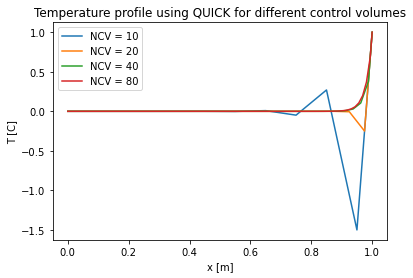

In [271]:
%matplotlib inline
import matplotlib.pyplot as plt

fig3, ax = plt.subplots()


ax.plot(grid1, T_QUICK1, label="NCV = 10")
ax.plot(grid2, T_QUICK2, label="NCV = 20")
ax.plot(grid3, T_QUICK3, label="NCV = 40")
ax.plot(grid4, T_QUICK4, label="NCV = 80")


ax.set_title("Temperature profile using QUICK for different control volumes")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## Analytical Solution

In [276]:
#Define the grid for x values:

x_an = grid.xP

#Define Pe
Pe = 50

#Define Temperatures
T1 = 0
T2 = 1

#Temperature calculation

T_an = T1 + ((((np.exp((x_an*Pe)/lx))-1)/(np.exp(Pe)-1))*(T2-T1))

print (T_an)


[0.00000000e+00 2.84323108e-20 6.30511483e-16 1.38879439e-11
 3.05902321e-07 6.73794700e-03 1.00000000e+00]


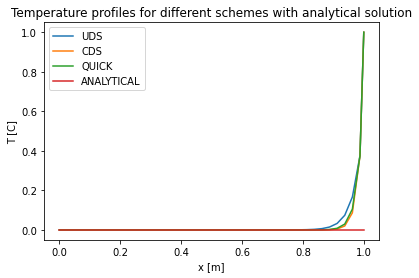

In [275]:
%matplotlib inline
import matplotlib.pyplot as plt

fig4, ax = plt.subplots()


ax.plot(x_an, T_UDS3, label="UDS")
ax.plot(x_an, T_CDS3, label="CDS")
ax.plot(x_an, T_QUICK3, label="QUICK")
ax.plot(x_an, T_an, label="ANALYTICAL")


ax.set_title("Temperature profiles for different schemes with analytical solution")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## Problem 2

Consider the problem of water flowing through a heated square duct (see the figure below).

![Problem1](Figures/3-Problem2.png)

The properties of water are $\rho$ = 1000 [kg/m$^3$], $k$ = 0.590 [W/m$\cdot$K], and $c_p$ = 4189 [J/kg$\cdot$K]. The exact solution for this problem is:

$$
    \frac{T_{\infty}-T(x)}{T_{\infty}-T_{in}}= e^{-\frac{h P_o x}{\dot{m} c_p}}
$$

To solve this problem, start with 5 equal-length control volumes, initialize the temperature and velocity fields as $T$ = 0 [$^\circ$C] and $u$ = 1.5 [m/s], and use a time-step size of $10^{10}$ [s].  At the left boundary, set $\alpha_e = 1$ to ensure that the correct value of $T$ gets carried into the domain.  Then, carry out the following:

1. Solve the problem using UDS, CDS and QUICK and plot $T$ for all schemes along with $T_{exact}$ vs. $x$ with $\alpha_e$ = -1.0 at the right boundary.  Discuss the results.
2. Test the effect of $\alpha_e$ at the right boundary.  That is, set $\alpha_e$ = 1.0 at the right boundary, run the cases of (1) again and discuss the differences that occur.  What physical effect does setting $\alpha_e = \pm1.0$ at the right boundary have?  Which is realistic?
3. Reverse the flow direction and the boundary conditions re-run parts (1) and (2).  Show plots of $T$ vs. $x$.  Make sure you use appropriate values for $\alpha_e$ on the boundaries.  Your solutions should be the same as those from parts (1) and (2), except opposite.

Based on your results for this problem, make a general statement about how $\alpha_e$ should be set on the boundaries and why.

# Solution Problem 2

### Class definition for positive flow direction for UDS, CDS and QUICK schemes with alphae on the right boundary positive.

In [ ]:
import numpy as np

class UpwindAdvectionModel1:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1 #Left boundary
        self._alphae [-1] = -1 #Right boundary
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [ ]:
class CenteredAdvectionModel1:
    """Class defining an upwind advection model with a central difference scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1 #Left boundary
        self._alphae [-1] = 1 #Right boundary
        
       # Calculate the east integration point values (including both boundaries)
        self._phie[1:-1] = (self._phi[1:-2] + self._phi[2:-1])/2
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]
         

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = (self._cp*mdote[:-1]/2)*self._phie[:-1]
        flux_e = (self._cp*mdote[1:]/2)*self._phie[1:]
        
        #flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        #flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

## For UDS

In [ ]:
from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel, FirstOrderTransientModel
from Classes.LinearSolver import solve

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 10e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 100

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0
U0 = 1.5 #m/s

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = UpwindAdvectionModel1(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT

## For CDS

In [ ]:
# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 10e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 100

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0
U0 = 1.5 #m/s

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = CenteredAdvectionModel1(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT